In [95]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

import tensorflow as tf
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()


,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [4]:
# bins = [0,1,2,3]
# review_names = ['excellent', 'good', 'bad']
# train['ratingCategorical'] = pd.cut(train['ratingCategory'], bins, labels=review_names, include_lowest=True, right=False)

In [5]:
train.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [6]:
test.head()

,id,description
0,3461,\nStyle: Speyside single malt scotch Color: Wa...
1,2604,"\nVery bright and lively, with a nice balance ..."
2,3341,\nA new oloroso-forward Chivas positioned to s...
3,3764,\nAged in bourbon casks and then enhanced in R...
4,2306,\nThere is a freshness to the wood on the nose...


In [7]:
sample.head()


,id,ratingCategory
0,3461,2
1,2604,2
2,3341,2
3,3764,2
4,2306,2


In [8]:
import re
def preprocess_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
train['description'] = train['description'].apply(preprocess_text)
test['description'] = test['description'].apply(preprocess_text)

In [10]:
# del train['ratingCategory']


In [11]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [12]:
# TODO we may have to reassign y because I am not encoding the categorical anylonger 
# lbl_enc = preprocessing.LabelEncoder()
# y = lbl_enc.fit_transform(train.ratingCategorical.values)

y = train['ratingCategory']
print(y)

0       1
1       0
2       1
3       1
4       1
       ..
4082    1
4083    1
4084    1
4085    1
4086    1
Name: ratingCategory, Length: 4087, dtype: int64


In [13]:
train.head()

,id,description,ratingCategory
0,1321,Sometimes when whisky is batched few leftover...,1
1,3861,An uncommon exclusive bottling of year old ca...,0
2,655,This release is port version of Amrut Interme...,1
3,555,This year old single cask was aged in sherry ...,1
4,1965,Quite herbal on the nose with aromas of dried...,1


In [14]:
train.shape

(4087, 3)

In [15]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.description.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)


In [16]:
xtrain[:3]

array([' This is straightforward straight shootin Irish whiskey Creamy country fudge toasted muffins glorious sweet malt waxed lemons and delicate spices on the first sniff It light in the mouth with lemon curd juicy caramels and vanilla custard tarts simply bursting with warmth It concludes with spices twinkling on malt theme Have your Irish whiskey experiences only been with the big names Go live little You ought to get this sugar and spice and all things nice ',
       ' Nashville restaurant Peg Leg Porker pitmaster Carey Bringle filters this whiskey through hickory charcoal Malted milk balls peanuts in the shell toasted grain Swiss Miss hot cocoa mix licorice root beer and tea leaves to start with lots of oak dark chocolate blackberry white pepper cinnamon cherry cough syrup and more root beer on the sweet spiced palate The finish is delicate and fruited with sweet cherries and blackberries as well as sprinkling of cloves and subtle oak ',
       ' growing number of Canadian craft 

In [17]:
ytrain[:3]

1362    1
2710    1
2490    1
Name: ratingCategory, dtype: int64

In [18]:
xvalid[:3]

array([' Stick your snout into aromas of rich tea biscuits honey tangerine toasted almond chips candied pineapple chunks and prickle of spice It youthful but integrated the grain domineering over the malt likable flavor sequence begins with lovely honey sweetness honeydew melon and pear before citrus phase followed by an ominous wave of spice which vanquishes the sweet fruits leaving swift spicy finish bottles for S ',
       ' The appealing nose features pretty biscuit notes great purity of malt and golden honeyed sweetness before adding some flavors of citrus blossom clover and cardamom with hints of licorice On the palate the initial sweet malt quickly turns herbal with marjoram and distinct sage note that lingers through long finish of salt tinged sweetness Aged years months in full size charred oak ',
       ' Independent bottler Gordon MacPhail offers variety of Balblair expressions including vintage and this year old in their Distillery Labels series Matured in mixture of refill

In [19]:
yvalid[:3]

1286    1
1585    1
1950    1
Name: ratingCategory, dtype: int64

In [20]:
print (xtrain.shape)
print (xvalid.shape)

(3678,)
(409,)


In [21]:
xtest = np.asarray(test['description'])

In [22]:
xtest[:3]

array([' Style Speyside single malt scotch Color Walnut Aroma Richly sherried and thick with notes of nuts and toffee Wood resins contribute spice and variety Fruitcake at Christmas Palate Thick chewy in texture and quite ripe Again the fruitcake Very deep and mature with some underlying maltiness Dry spicy oak notes fight off all that sherry and add balance and complexity Long soothing finish ',
       ' Very bright and lively with nice balance of flavors Zesty fruit lemon peach ripe pineapple golden raisin on bed of layered sweetness creamy vanilla light honey lightly toasted marshmallow and hint of coconut Gently dry delicately spicy dried citrus finish Light enough and with enough zing to enjoy before dinner but it should stand up well enough after dinner too This is nice whisky but it shows lighter more elegant side of Glenrothes It doesn express the rich opulent notes often shown in bottlings like the Vintage for example ',
       ' new oloroso forward Chivas positioned to split 

In [23]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)
xtest_tfv = tfv.transform(xtest)

In [24]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.556 


In [25]:
predictions

array([[0.11911593, 0.87169094, 0.00919313],
       [0.32056241, 0.66214529, 0.0172923 ],
       [0.11200454, 0.88048324, 0.00751223],
       ...,
       [0.12922978, 0.8580907 , 0.01267952],
       [0.44248012, 0.53661303, 0.02090685],
       [0.1880043 , 0.80331342, 0.00868229]])

In [26]:
test_predictions = clf.predict_proba(xtest_tfv)


In [27]:
test_predictions

array([[0.24074484, 0.74598284, 0.01327232],
       [0.30008709, 0.68704451, 0.01286839],
       [0.24420319, 0.74293926, 0.01285756],
       ...,
       [0.23473   , 0.74623609, 0.01903391],
       [0.28933964, 0.69529618, 0.01536418],
       [0.52683154, 0.42925388, 0.04391458]])

In [28]:
labels = np.argmax(test_predictions, axis=-1)    
print(labels)

[1 1 1 ... 1 1 0]


In [29]:
labels 

array([1, 1, 1, ..., 1, 1, 0])

In [30]:
sample.head()

,id,ratingCategory
0,3461,2
1,2604,2
2,3341,2
3,3764,2
4,2306,2


In [31]:
sample['rating']=labels

In [32]:
sample.head()

,id,ratingCategory,rating
0,3461,2,1
1,2604,2,1
2,3341,2,1
3,3764,2,1
4,2306,2,1


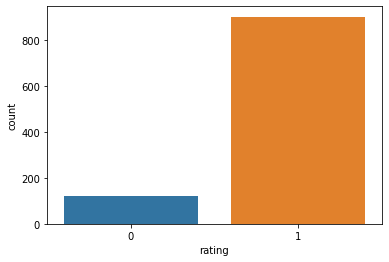

In [33]:
import seaborn as sns

sns.countplot(x='rating', data=sample)

In [34]:
sample['rating'].value_counts()

1    901
0    121
Name: rating, dtype: int64

In [35]:

# Think got a 56% first run round 
# then 55.6% ok moving right along 

In [36]:
xtrain_tfv

<3678x16029 sparse matrix of type '<class 'numpy.float64'>'
	with 202871 stored elements in Compressed Sparse Row format>

In [37]:
xvalid_tfv

<409x16029 sparse matrix of type '<class 'numpy.float64'>'
	with 22814 stored elements in Compressed Sparse Row format>

In [38]:
xtest_tfv

<1022x16029 sparse matrix of type '<class 'numpy.float64'>'
	with 51866 stored elements in Compressed Sparse Row format>

In [39]:
sample.head()


,id,ratingCategory,rating
0,3461,2,1
1,2604,2,1
2,3341,2,1
3,3764,2,1
4,2306,2,1


In [40]:
sample.head()

,id,ratingCategory,rating
0,3461,2,1
1,2604,2,1
2,3341,2,1
3,3764,2,1
4,2306,2,1


In [41]:
del sample['ratingCategory']


In [42]:
sample.rename(columns = {'rating':'ratingCategory'}, inplace = True) 

In [43]:
sample

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1
...,...,...
1017,2853,1
1018,219,1
1019,1286,1
1020,2201,1


In [44]:
subNumber = 1000

In [45]:
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':sample['ratingCategory']})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')

submission.to_csv(f'../data/submission{subNumber}.csv', index=False)


# next 
instead of tfidf
word counts as features
using CountVectorizer from scikit-learn.

In [46]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [47]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.636 


In [48]:
# acc 63.6

# Naive Bayes

In [49]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.683 


In [50]:
# acc 68.3

In [51]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 3.695 


# Applying SVD and then simple SVM 

In [52]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [53]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.534 


# XG Boost 

In [54]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.580 


In [55]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_ctv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.585 


In [56]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.646 


In [57]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.672 


# Moving onto pipelines 

so far the best performing has been XG boost on tf-idf svd features 

In [58]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)


In [59]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [60]:
param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

In [61]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  12 out of  24 | elapsed:    6.7s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:    7.2s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  18 out of  24 | elapsed:    8.0s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  21 out of  24 | elapsed:    8.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    9.3s finished


Best score: -0.586
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l2'
	svd__n_components: 120


# next pipeline attempt

In [62]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(xtrain_tfv, ytrain)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best score: -0.650
Best parameters set:
	nb__alpha: 0.1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0472s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished


# GLOVE VECTORS !!!! 

In [63]:
# import os
# from numpy import asarray

# load the GloVe vectors in a dictionary:

# embeddings_index = {}
# f = open('glove.840B.300d.txt')
# for line in tqdm(f):
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))



# l.decode('utf8').strip().split(' ')
embeddings_index = {}
f = open('glove.840B.300d.txt')
for line in tqdm(f):
    values = line.strip().split(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


2196017it [03:00, 12141.47it/s]


Found 2196007 word vectors.


In [64]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower() # commented out decode .decode('utf-8')
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [65]:
import nltk


In [66]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [70]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
xtest_glove = [sent2vec(x) for x in tqdm(xtest)]

100%|██████████| 1022/1022 [00:01<00:00, 918.09it/s]


In [71]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
xtest_glove = np.array(xtest_glove)

SyntaxError: invalid syntax (<ipython-input-69-2719983566c3>, line 1)

# XG Boost on GLOVE 

In [72]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.745 


# !!!  Stop here and make a prediction. loglogg 0.745 !!! ------------------- *** 

In [73]:
# Test Prediction Sequence 1/4
test_predictions = clf.predict_proba(xtest_glove)
labels = np.argmax(test_predictions, axis=-1)    

[1 1 1 ... 1 1 0]


In [76]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/submission{subNumber}.csv', index=False)


In [84]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

1    866
0    156
Name: ratingCategory, dtype: int64

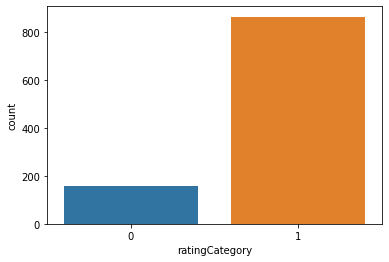

In [81]:
# Test Prediction Sequence 4/4

sns.countplot(x='ratingCategory', data=submission);

In [86]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.693 


In [87]:
# Test Prediction Sequence 1/4
test_predictions = clf.predict_proba(xtest_glove)
labels = np.argmax(test_predictions, axis=-1)    

In [91]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/submission{subNumber}.csv', index=False)
print(subNumber)

In [89]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

1    878
0    144
Name: ratingCategory, dtype: int64

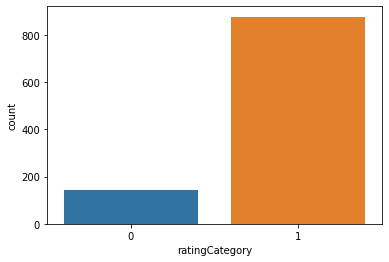

In [90]:
# Test Prediction Sequence 4/4

sns.countplot(x='ratingCategory', data=submission);

# Deep learning 

In [96]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)
xtest_glove_scl = scl.transform(xtest_glove)

In [97]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [98]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [100]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=15, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Train on 3678 samples, validate on 409 samples
Epoch 1/15
3678/3678 [==============================] - 0s 84us/step - loss: 0.4089 - val_loss: 0.5977
Epoch 2/15
3678/3678 [==============================] - 0s 79us/step - loss: 0.3590 - val_loss: 0.6266
Epoch 3/15
3678/3678 [==============================] - 0s 76us/step - loss: 0.3240 - val_loss: 0.6398
Epoch 4/15
3678/3678 [==============================] - 0s 76us/step - loss: 0.3012 - val_loss: 0.6613
Epoch 5/15
3678/3678 [==============================] - 0s 74us/step - loss: 0.2888 - val_loss: 0.6403
Epoch 6/15
3678/3678 [==============================] - 0s 79us/step - loss: 0.2435 - val_loss: 0.6547
Epoch 7/15
3678/3678 [==============================] - 0s 76us/step - loss: 0.2194 - val_loss: 0.7095
Epoch 8/15
3678/3678 [==============================] - 0s 75us/step - loss: 0.2106 - val_loss: 0.7641
Epoch 9/15
3678/3678 [==============================] - 0s 75us/step - loss: 0.1859 - val_loss: 0.7405
Epoch 10/15
3678/3678 [===

### get accuracy and a submission before moving on

### ---------------- ** --------------------

In [101]:
# Test Prediction Sequence 1/4
test_predictions = model.predict_proba(xtest_glove_scl)
labels = np.argmax(test_predictions, axis=-1)    

In [103]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/deepsub{subNumber}.csv', index=False)
print(subNumber)

1006


In [104]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

1    742
0    278
2      2
Name: ratingCategory, dtype: int64

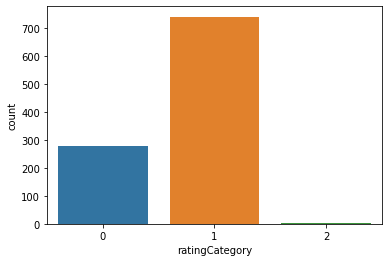

In [105]:
# Test Prediction Sequence 4/4
sns.countplot(x='ratingCategory', data=submission);

## Using Keras Tokenizer

In [110]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
xtest_seq = token.texts_to_sequences(xtest)


# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len)

word_index = token.word_index

In [111]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


100%|██████████| 12377/12377 [00:00<00:00, 52279.80it/s]


In [112]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [113]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Train on 3678 samples, validate on 409 samples
Epoch 1/100
3678/3678 [==============================] - 5s 1ms/step - loss: 0.8134 - val_loss: 0.6947
Epoch 2/100
3678/3678 [==============================] - 4s 1ms/step - loss: 0.7008 - val_loss: 0.6564
Epoch 3/100
3678/3678 [==============================] - 4s 1ms/step - loss: 0.6749 - val_loss: 0.6726
Epoch 4/100
3678/3678 [==============================] - 4s 1ms/step - loss: 0.6662 - val_loss: 0.6533
Epoch 5/100
3678/3678 [==============================] - 4s 1ms/step - loss: 0.6603 - val_loss: 0.6476
Epoch 6/100
3678/3678 [==============================] - 4s 1ms/step - loss: 0.6500 - val_loss: 0.6293
Epoch 7/100
3678/3678 [==============================] - 5s 1ms/step - loss: 0.6484 - val_loss: 0.6133
Epoch 8/100
3678/3678 [==============================] - 4s 1ms/step - loss: 0.6370 - val_loss: 0.5965
Epoch 9/100
3678/3678 [==============================] - 5s 1ms/step - loss: 0.6289 - val_loss: 0.6045
Epoch 10/100
3678/3678 [==

In [115]:
# Test Prediction Sequence 1/4
test_predictions = model.predict_proba(xtest_pad)
labels = np.argmax(test_predictions, axis=-1)    

In [116]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/deepsub{subNumber}.csv', index=False)
print(subNumber)

1007


In [117]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

1    752
0    268
2      2
Name: ratingCategory, dtype: int64

In [ ]:
# Test Prediction Sequence 4/4
sns.countplot(x='ratingCategory', data=submission);

# Implement Early Stopping 

We see that the score is now less than 0.5. I ran it for many epochs without stopping at the best but you can use early stopping to stop at the best iteration. How do I use early stopping?

well, pretty easy. let's compile the model again:

# A simple LSTM with glove embeddings and two dense layers


In [120]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])



Train on 3678 samples, validate on 409 samples
Epoch 1/100
3678/3678 [==============================] - 13s 4ms/step - loss: 0.7794 - val_loss: 0.6766
Epoch 2/100
3678/3678 [==============================] - 13s 3ms/step - loss: 0.6850 - val_loss: 0.6749
Epoch 3/100
3678/3678 [==============================] - 14s 4ms/step - loss: 0.6684 - val_loss: 0.6710
Epoch 4/100
3678/3678 [==============================] - 14s 4ms/step - loss: 0.6663 - val_loss: 0.6384
Epoch 5/100
3678/3678 [==============================] - 14s 4ms/step - loss: 0.6513 - val_loss: 0.6268
Epoch 6/100
3678/3678 [==============================] - 14s 4ms/step - loss: 0.6399 - val_loss: 0.5925
Epoch 7/100
3678/3678 [==============================] - 13s 4ms/step - loss: 0.6362 - val_loss: 0.5869
Epoch 8/100
3678/3678 [==============================] - 13s 3ms/step - loss: 0.6281 - val_loss: 0.5951
Epoch 9/100
3678/3678 [==============================] - 13s 4ms/step - loss: 0.6475 - val_loss: 0.5924
Epoch 10/100
3678

In [121]:
# Test Prediction Sequence 1/4
test_predictions = model.predict_proba(xtest_pad)
labels = np.argmax(test_predictions, axis=-1)

In [122]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/deepsub{subNumber}.csv', index=False)
print(subNumber)

1008


In [123]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

1    859
0    163
Name: ratingCategory, dtype: int64

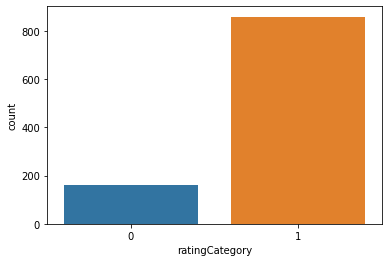

In [124]:
# Test Prediction Sequence 4/4
sns.countplot(x='ratingCategory', data=submission);

# A simple bidirectional LSTM with glove embeddings and two dense layers


In [125]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])


Train on 3678 samples, validate on 409 samples
Epoch 1/100
3678/3678 [==============================] - 31s 8ms/step - loss: 0.8207 - val_loss: 0.7126
Epoch 2/100
3678/3678 [==============================] - 29s 8ms/step - loss: 0.6969 - val_loss: 0.6692
Epoch 3/100
3678/3678 [==============================] - 26s 7ms/step - loss: 0.6784 - val_loss: 0.6488
Epoch 4/100
3678/3678 [==============================] - 25s 7ms/step - loss: 0.6687 - val_loss: 0.6339
Epoch 5/100
3678/3678 [==============================] - 24s 6ms/step - loss: 0.6557 - val_loss: 0.6475
Epoch 6/100
3678/3678 [==============================] - 25s 7ms/step - loss: 0.6458 - val_loss: 0.6016
Epoch 7/100
3678/3678 [==============================] - 25s 7ms/step - loss: 0.6372 - val_loss: 0.5844
Epoch 8/100
3678/3678 [==============================] - 27s 7ms/step - loss: 0.6207 - val_loss: 0.5794
Epoch 9/100
3678/3678 [==============================] - 28s 8ms/step - loss: 0.6106 - val_loss: 0.5776
Epoch 10/100
3678

In [126]:
# Test Prediction Sequence 1/4
test_predictions = model.predict_proba(xtest_pad)
labels = np.argmax(test_predictions, axis=-1)

In [127]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/deepsub{subNumber}.csv', index=False)
print(subNumber)

1009


In [128]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

1    783
0    239
Name: ratingCategory, dtype: int64

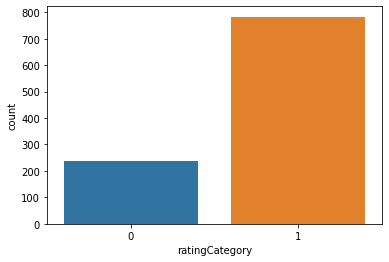

In [129]:
# Test Prediction Sequence 4/4
sns.countplot(x='ratingCategory', data=submission);

# 2 GRU and Two Dense Layers

In [130]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

Train on 3678 samples, validate on 409 samples
Epoch 1/100
3678/3678 [==============================] - 26s 7ms/step - loss: 8.8135 - val_loss: 0.8121
Epoch 2/100
3678/3678 [==============================] - 26s 7ms/step - loss: 5.6153 - val_loss: 0.7471
Epoch 3/100
3678/3678 [==============================] - 24s 6ms/step - loss: 5.5030 - val_loss: 0.7167
Epoch 4/100
3678/3678 [==============================] - 25s 7ms/step - loss: 5.3194 - val_loss: 0.7100
Epoch 5/100
3678/3678 [==============================] - 23s 6ms/step - loss: 6.0983 - val_loss: 0.7204
Epoch 6/100
3678/3678 [==============================] - 23s 6ms/step - loss: 5.8313 - val_loss: 0.7019
Epoch 7/100
3678/3678 [==============================] - 22s 6ms/step - loss: 5.8204 - val_loss: 0.7271
Epoch 8/100
3678/3678 [==============================] - 22s 6ms/step - loss: 6.1869 - val_loss: 0.7120
Epoch 9/100
3678/3678 [==============================] - 23s 6ms/step - loss: 5.7118 - val_loss: 0.6655
Epoch 10/100
3678

In [131]:
# Test Prediction Sequence 1/4
test_predictions = model.predict_proba(xtest_pad)
labels = np.argmax(test_predictions, axis=-1)

In [132]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/deepsub{subNumber}.csv', index=False)
print(subNumber)

1010


In [133]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

1    1022
Name: ratingCategory, dtype: int64

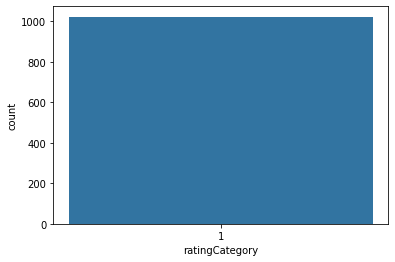

In [134]:
# Test Prediction Sequence 4/4
sns.countplot(x='ratingCategory', data=submission);

# Ensembler 

In [135]:
# this is the main ensembling class. how to use it is in the next cell!
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import os
import sys
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [136]:
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [xtrain_tfv, xtrain_ctv, xtrain_tfv, xtrain_ctv], 1: [xtrain_glove]}
test_data_dict = {0: [xvalid_tfv, xvalid_ctv, xvalid_tfv, xvalid_ctv], 1: [xvalid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='./')

ens.fit(train_data_dict, ytrain, lentrain=xtrain_glove.shape[0])
preds = ens.predict(test_data_dict, lentest=xvalid_glove.shape[0])

[12:40:21] INFO Found 3 classes
[12:40:21] INFO Training Level 0 Fold # 1. Model # 0
[12:40:21] INFO Predicting Level 0. Fold # 1. Model # 0
[12:40:21] INFO Level 0. Fold # 1. Model # 0. Validation Score = 0.582691
[12:40:21] INFO Training Level 0 Fold # 2. Model # 0
[12:40:22] INFO Predicting Level 0. Fold # 2. Model # 0
[12:40:22] INFO Level 0. Fold # 2. Model # 0. Validation Score = 0.579270
[12:40:22] INFO Training Level 0 Fold # 3. Model # 0
[12:40:22] INFO Predicting Level 0. Fold # 3. Model # 0
[12:40:22] INFO Level 0. Fold # 3. Model # 0. Validation Score = 0.580537
[12:40:22] INFO Level 0. Model # 0. Mean Score = 0.580833. Std Dev = 0.001412
[12:40:22] INFO Training Level 0 Fold # 1. Model # 1
[12:40:30] INFO Predicting Level 0. Fold # 1. Model # 1
[12:40:30] INFO Level 0. Fold # 1. Model # 1. Validation Score = 0.693722
[12:40:30] INFO Training Level 0 Fold # 2. Model # 1
[12:40:38] INFO Predicting Level 0. Fold # 2. Model # 1
[12:40:38] INFO Level 0. Fold # 2. Model # 1. Val

In [137]:
preds

{0: array([[1.19115934e-01, 8.71690937e-01, 9.19312909e-03, ...,
         9.87111768e-04, 9.99012888e-01, 3.70368977e-37],
        [3.20562409e-01, 6.62145289e-01, 1.72923027e-02, ...,
         2.41173872e-02, 9.75882613e-01, 2.93887953e-37],
        [1.12004538e-01, 8.80483236e-01, 7.51222584e-03, ...,
         6.38505690e-20, 1.00000000e+00, 7.11279159e-77],
        ...,
        [1.29229780e-01, 8.58090698e-01, 1.26795216e-02, ...,
         1.62375245e-06, 9.99998376e-01, 1.91422431e-40],
        [4.42480122e-01, 5.36613025e-01, 2.09068523e-02, ...,
         9.99817547e-01, 1.82452803e-04, 4.07985734e-27],
        [1.88004296e-01, 8.03313417e-01, 8.68228698e-03, ...,
         1.75907028e-12, 1.00000000e+00, 1.55564351e-71]]),
 1: array([[7.88316038e-03, 9.92106080e-01, 1.07203859e-05],
        [1.96564108e-01, 8.02066684e-01, 1.36921543e-03],
        [1.40753854e-02, 9.85908449e-01, 1.61019580e-05],
        ...,
        [5.81979239e-03, 9.94171321e-01, 8.87629358e-06],
        [2.026

In [138]:
# Test Prediction Sequence 1/4
# test_predictions = model.predict_proba(xtest_pad)
labels = np.argmax(preds, axis=-1)

In [139]:
# Test Prediction Sequence 2/4
subNumber += 1
submission = pd.DataFrame({'id': sample['id'], 'ratingCategory':labels})
# submission['ratingCategory'] = submission['ratingCategory'].astype('int64')
submission.to_csv(f'../data/deepsub{subNumber}.csv', index=False)
print(subNumber)

1011


In [140]:
# Test Prediction Sequence 3/4
submission['ratingCategory'].value_counts()

0    1022
Name: ratingCategory, dtype: int64

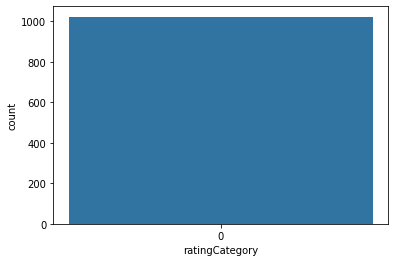

In [141]:
# Test Prediction Sequence 4/4
sns.countplot(x='ratingCategory', data=submission);